Task: Build an autoencoder model to improve the clarity of dental X-rays (denoise the X-rays) using the dental panoramic dataset. 

Dataset: Dental-Panaromic-Autoencoder.npz

This dataset consists of anonymized and de-identified panoramic dental X-rays of 116 patients, taken at Noor Medical Imaging Center, Qom, Iran. The subjects cover a wide range of dental conditions from healthy, to partial, and complete edentulous cases. The mandibles of all cases are manually segmented by two dentists. The dataset is saved in compressed NumPy format which when loaded using numpy.load will give you x_train, y_train, x_test and y_test NumPy arrays respectively.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


Task A:
Load the Dental-Panaromic-Autoencoder.npz dataset using NumPy.load. 
Note: NPZ is a file format by NumPy that provides storage of array data using gzip compression.

In [16]:
#Load the Dental-Panaromic-Autoencoder.npz dataset using NumPy.load. 
data = np.load('DENTAL~1.NPZ')

Extract x_train, y_train, x_test and y_test numpy arrays from the dataset

In [17]:
x_test = data['x_test']
y_test = data['y_test']
x_train = data['x_train']
y_train = data['y_train']


A noisy version of the dataset will be created by applying random noise to each image.
With a noise factor of 0.2, add noise to the signal by multiplying the noise factor and random values from a normal distribution. 

Hint: 
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 

x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

Clip the signal values between 0 and 1

In [18]:
#add noise With a noise factor of 0.2, add noise to the signal by multiplying the noise factor and random values from a normal distribution. 
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [19]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Plot the first 5 Xray images from original images (x_train)

<Figure size 1000x200 with 0 Axes>

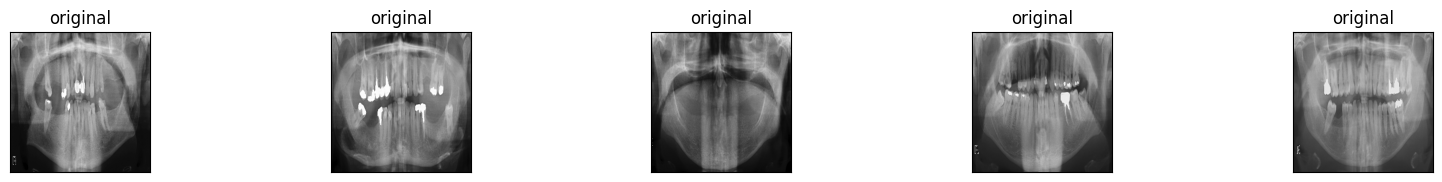

In [20]:
# Plot the first 5 images
plt.figure(figsize=(10, 2))
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.autumn()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

Plot the first 5 Xray images from noise images (x_train_noisy)

<Figure size 1000x200 with 0 Axes>

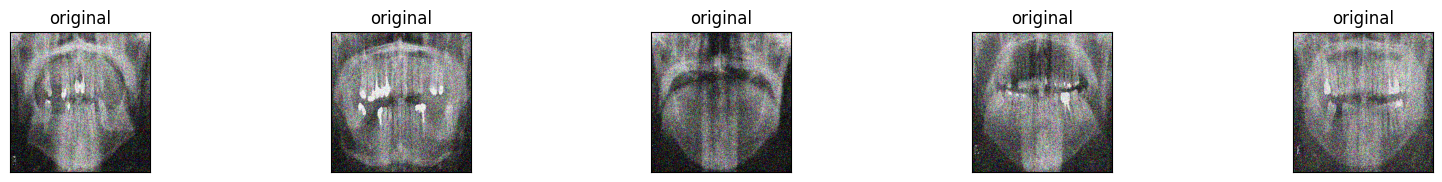

In [21]:
# Plot the first 5 images
plt.figure(figsize=(10, 2))
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train_noisy[i])
  plt.title("original")
  plt.autumn()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [22]:
x_train_noisy = x_train_noisy.reshape((len(x_train_noisy), 256, 256, 3))
x_test_noisy = x_test_noisy.reshape((len(x_test_noisy), 256, 256, 3))
#Reshape the data to 256x256x3
x_train = x_train.reshape((len(x_train), 256, 256, 3))
x_test = x_test.reshape((len(x_test), 256, 256, 3))

Train an autoencoder using the noisy image as the input and the original image as the destination. The images are shaped 256x256 in RGB scale
Create a Denoise class inherited from Keras Model 
The class has an encoder member variable of the following layers:
Input Layer of shape 256*256*3
Conv2D with 64 filters, kernel size 3,3, activation relu and same padding and strides 2
Conv2D with 32 filters, kernel size 3,3, activation relu and same padding and strides 2
The class has a decoder member variable of below layers
Conv2DTranspose with 32 filters, kernel size 3,3, activation relu and same padding and stride 2

In [23]:
class DenoiseModel(tf.keras.Model):
    def __init__(self):
        super(DenoiseModel, self).__init__()
        
        # Encoder layers
        self.encoder = models.Sequential([
            layers.Input(shape=(256, 256, 3)),  # Input Layer
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
        ])
        
        # Decoder layers
        self.decoder = models.Sequential([
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', strides=2)  # Output layer
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Task A:
Train an autoencoder using the noisy image as the input and the original image as the destination. The images are shaped 256x256 in RGB scale (cont.)
Conv2DTranspose with 64 filters, kernel size 3,3, activation relu and same padding and stride 2
Conv2D with 1 filter, kernel size 3,3, activation sigmoid and same padding
Create a call member function to the class  which will pass the input to the encoder member function and the output of the encoder to the decoder member function

Initialize the autoencoder object of the class Denoise
Compile the autoencoder with Adam optimizer and MeanSquaredError as loss

In [24]:
autoencoder = DenoiseModel()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['mae'])

Train the autoencoder with X as x_train_noisy and Y as x_train for 10 epochs and validation data as x_test_noisy and x_test

In [25]:
history = autoencoder.fit(x_train_noisy, x_train,epochs=50, validation_data=(x_test_noisy, x_test))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.0526 - mae: 0.1825 - val_loss: 0.0526 - val_mae: 0.1824
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0537 - mae: 0.1847 - val_loss: 0.0523 - val_mae: 0.1819
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0531 - mae: 0.1839 - val_loss: 0.0518 - val_mae: 0.1811
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0520 - mae: 0.1820 - val_loss: 0.0509 - val_mae: 0.1796
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0517 - mae: 0.1815 - val_loss: 0.0495 - val_mae: 0.1769
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0491 - mae: 0.1765 - val_loss: 0.0471 - val_mae: 0.1725
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0463 - mae: 0.1709 - val_loss: 0.0433 - val_mae: 0.1641
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0417 - mae: 0.1607 - val_loss: 0.0380 - val_mae: 0.1530
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0360 - mae: 

Plot training and validation MAE and loss against epochs

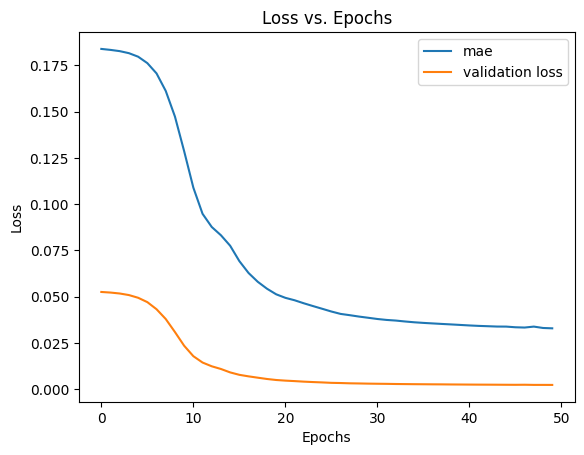

In [26]:
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Task B:
Evaluate the autoencoder model on x_test
Pass the x_test into the encoder
Pass the encoded images into the decoder. This step gives the decoded images that are reconstructed from the original.
Plot both the first 10 noisy images (x_test_noisy) and images without noise produced by the autoencoder.  Check how well the AutoEncoder model has done the job with denoising.

In [27]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

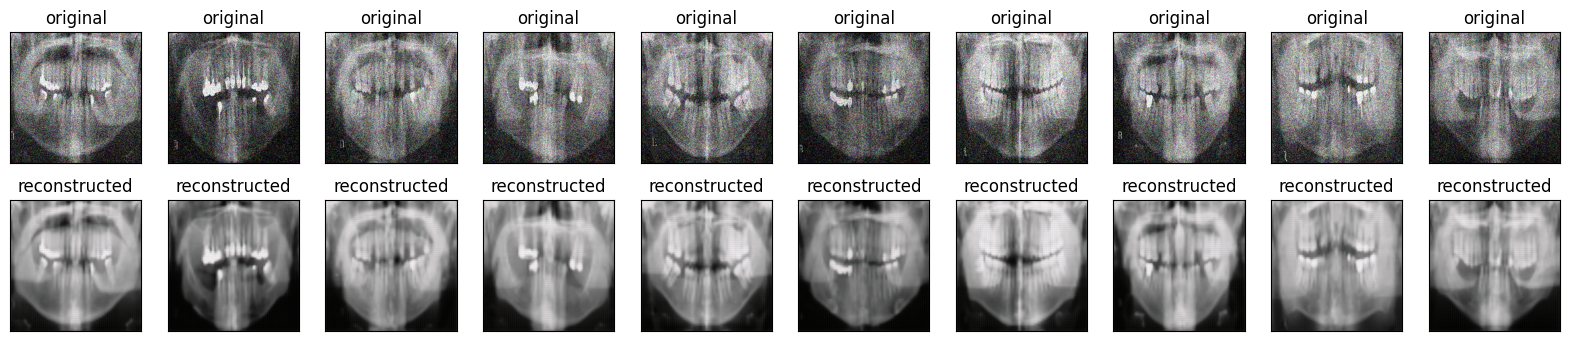

In [28]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_noisy[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()